# **Strat Case Study**

---

### Author: Dimitris Bekos
#### Date: 2024-06-22

---


## Question 1

### **Objective**
**Question 1**: Consolidate the Static and Historic Data provided into a single pandas dataframe to allow for easier data exploration and facilitate future analysis.

### **Steps**
1. **Import Libraries**: Import pandas and a custom function to clean column names.
2. **Cleanse Tabular Data**: A function that identifies the correct header row, cleans column names, drops empty columns, resets the index, and converts data types to numeric or datetime.
3. **Load and Clean Excel Sheets**: A function that reads all sheets from an Excel file, filters sheets based on a pattern name, cleanses each sheet's data, and ensures consistency in the number of rows across all sheets.
4. **Usage**: Example usage of the `load_and_clean_excel` function to load and cleanse data from an Excel file.


In [1]:
#Step 1

from excel_parser.load_and_clean_tabular_data import load_and_clean_excel

# Load and clean the Excel file
file_path = '2024 - Strat Casestudy.xlsx'

cleaned_dataframes = load_and_clean_excel(file_path)
#cleaned_dataframes['Static']

Could not find DATA in the tab name of Questions please check the name of the excel tab
Parsing DATA-Static..
DATA-Static Parsed. Dataframe shape is (1630, 8)
Parsing DATA-Month End Balances..
DATA-Month End Balances Parsed. Dataframe shape is (1630, 85)
Parsing DATA-Payment Due..
DATA-Payment Due Parsed. Dataframe shape is (1630, 85)
Parsing DATA-Payment Made..
DATA-Payment Made Parsed. Dataframe shape is (1630, 85)
Could not find DATA in the tab name of Simple Mortgage Model please check the name of the excel tab


## Question 2

### **Objective**
**Question 2**: Please add the provided calculated columns to the dataframe (plus any others you found helpful).

### **Steps**
1. **Import Required Libraries and Functions**: The code imports necessary libraries and functions for handling data, calculating metrics, and creating time series data.
2. **Define Metrics**: A dictionary named `metrics` is defined, mapping metric names to their respective functions.
3. **Create Time Series Data by ID and Date**: The `create_timeseries_by_id_and_date` function generates time series data by:
    1. **Checking for date columns** in the dataframes.
    2. **Combining loan-level data** from the dataframes.
    3. **Enriching the combined data** with additional tabular data.
    4. **Adding calculated metrics** to the final dataframe.
4. **Combine and Enrich Loan-Level Data**:
    - **`combine_loan_level_data`**: Merges dataframes by melting them into a long format and joining on `loan_id` and `date`.
    - **`enrich_with_tabular_data`**: Joins additional static tabular data to the timeseries data based on `loan_id`.
5. **Add Metrics to DataFrame**: The `add_metrics_to_df` function applies the defined metric functions to the dataframe, adding new columns with the calculated metric values.


In [2]:
from timeseries_formater.metric_functions import current_balance, seasoning, n_missed_payments, prepaid_in_month, \
    default_in_month, recovery_in_month, is_recovery_payment, time_to_reversion, is_post_seller_purchase_date, \
    postdefault_recoveries, prepayment_date, date_of_default, date_of_recovery, exposure_at_default, recovery_percent, \
    portfolio_prepayment_rate, cumulative_default_rate, cumulative_recovery_rate, months_since_default, year_of_default
from timeseries_formater.create_timeseries_by_trade_id import create_timeseries_by_id_and_date

metrics = {
    'current_balance': current_balance,
    'seasoning': seasoning,
    'n_missed_payments': n_missed_payments,
    'prepaid_in_month': prepaid_in_month,
    'default_in_month': default_in_month,
    'recovery_in_month': recovery_in_month,
    'is_recovery_payment': is_recovery_payment,
    'time_to_reversion': time_to_reversion,
    'is_post_seller_purchase_date': is_post_seller_purchase_date,
    'postdefault_recoveries': postdefault_recoveries,
    'prepayment_date': prepayment_date,
    'date_of_default': date_of_default,
    'date_of_recovery': date_of_recovery,
    'exposure_at_default': exposure_at_default,
    'recovery_percent': recovery_percent,
    'months_since_default': months_since_default,
    'year_of_default': year_of_default,
}

timeseries = create_timeseries_by_id_and_date(cleaned_dataframes, metrics)
# timeseries

## Question 3

### **Objective**
**Question 3**: Create a function that returns Prepayment Curves ("CPR") for the portfolio. The function should by default return CPR as a pandas series with an index of `seasoning' for the whole portfolio. 

### **Steps**
1. **Group Data**: The dataframe is grouped by the specified indices (default is `['seasoning']`).
2. **Initialize Previous Period Balance**: Set an initial balance excluding defaults to avoid division by zero.
3. **Calculate Prepayment Amount**: Invoke the `prepayment_amount` function to calculate the amount prepaid in each period.
4. **Loop Through Groups**:
    - For each group, compute the balance excluding defaults and the prepayment amount for the current period.
    - Calculate the Single Month Mortality (SMM) rate.
    - Convert the SMM to the annualized Conditional Prepayment Rate (CPR).
    - Store the results in a dictionary.
    - Update the previous period balance for the next iteration.
5. **Create DataFrame**: Convert the results list into a pandas DataFrame and sort by the specified group indices.
6. **Return**: The function returns a DataFrame with the calculated CPR values.


Text(0, 0.5, 'portfolio_prepayment_rate')

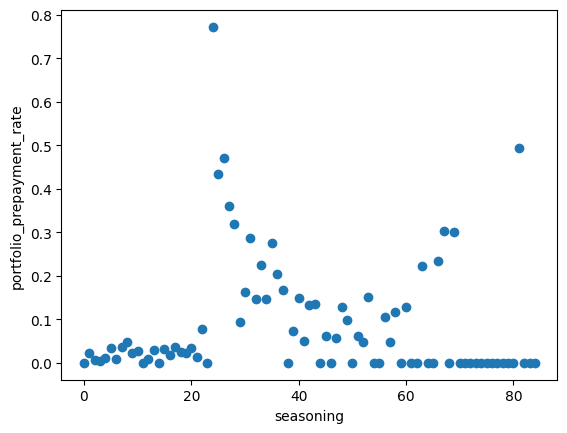

In [3]:
from matplotlib import pyplot as plt
prepayment_rate = portfolio_prepayment_rate(timeseries, ['seasoning'])
# plotting only when seasoning >= 0
plt.scatter(prepayment_rate.index[prepayment_rate.index >= 0], prepayment_rate.loc[prepayment_rate.index >= 0])
plt.xlabel('seasoning')
plt.ylabel('portfolio_prepayment_rate')

# PS. I am not 100% sure if the spike value is correct. It makes sense to see a spike there but I am not fully sure of the correctness of the amplitude. 
# It corresponds to 11% SMM which is probably ok for 1 month, but still seems a bit excessive.

## Question 4

### **Objective**
**Question 4**: Create a similar function for ("CDR") for the portfolio. The function should by default return CDR as a pandas series with an index of `seasoning' for the whole portfolio.

### **Steps**
1. **Group Data**: The dataframe is grouped by the specified indices (default is `['seasoning']`).
2. **Initialize Variables**: 
    - Set an initial balance excluding defaults to avoid division by zero.
    - Initialize arrays to track mortgages that have defaulted or prepaid before the current period.
3. **Loop Through Groups**:
    - For each group, compute the balance excluding defaults and prepayments for the current period.
    - Calculate the total defaults in the current period.
    - Compute the Monthly Default Rate (MDR).
    - Convert the MDR to the annualized Cumulative Default Rate (CDR).
    - Store the results in a dictionary.
    - Update the array tracking mortgages that defaulted or prepaid before the current period.
4. **Create DataFrame**: Convert the results list into a pandas DataFrame and sort by the specified group indices.
5. **Return**: The function returns a DataFrame with the calculated CDR values.

In [4]:
from matplotlib import pyplot as plt
default_rate = cumulative_default_rate(timeseries, ['seasoning'])
# plotting only when seasoning >= 0
plt.scatter(default_rate.index[default_rate.index >= 0], default_rate.loc[default_rate.index >= 0])
plt.xlabel('seasoning')
plt.ylabel('portfolio_default_rate')

Text(0, 0.5, 'portfolio_default_rate')

## Question 5

### **Objective**
**Question 5**: Create a similar function for Recovery Curves -- which shows the cumulative recovery as a % of exposure at default. This should only include loans that have defaulted and have an index of `months since default'.

### **Steps**

#### `post_default_recovery_by_month`
1. **Group Data by Loan ID**: The dataframe is grouped by the `loan_id` column.
2. **Initialize Recovery Column**: Add a new column `post_default_recovery_by_month` initialized to 0.
3. **Iterate Through Groups**:
    - For each group, check if any defaults occurred.
    - If defaults occurred, find the default date.
    - For each row in the group, if the date is after the default date, record the recovery payment.

#### `cumulative_recovery_rate`
1. **Calculate Post-Default Recovery**: Invoke the `post_default_recovery_by_month` function to calculate post-default recoveries.
2. **Group Data by Specified Indices**: The dataframe is grouped by the specified indices (default is `['seasoning']`).
3. **Initialize Variables**: Initialize variables to track total recoveries and defaults.
4. **Iterate Through Groups**:
    - For each group, sum the recoveries and defaults.
    - Calculate the recovery rate as the percentage of total recoveries over total defaults.
    - Store the results in a dictionary.
5. **Create DataFrame**: Convert the results list into a pandas DataFrame and sort by the specified group indices.
6. **Return**: The function returns a DataFrame with the calculated recovery rates.

In [5]:
from matplotlib import pyplot as plt
recovery_rate = cumulative_recovery_rate(timeseries, ['months_since_default'])
# plotting only when seasoning >= 0
plt.scatter(recovery_rate.index[recovery_rate.index >= 0], recovery_rate.loc[recovery_rate.index >= 0])
plt.xlabel('seasoning')
plt.ylabel('recovery_rate')

Text(0, 0.5, 'recovery_rate')

## Question 6

### **Objective**
**Question 6**: Using your function,  calculate Prepayment and Default Curves (vs. Time to Reversion); split by Product.

### **Steps**

1. **Using Existing Functionality**: Update the function pameters.
2. **Plotting the results**


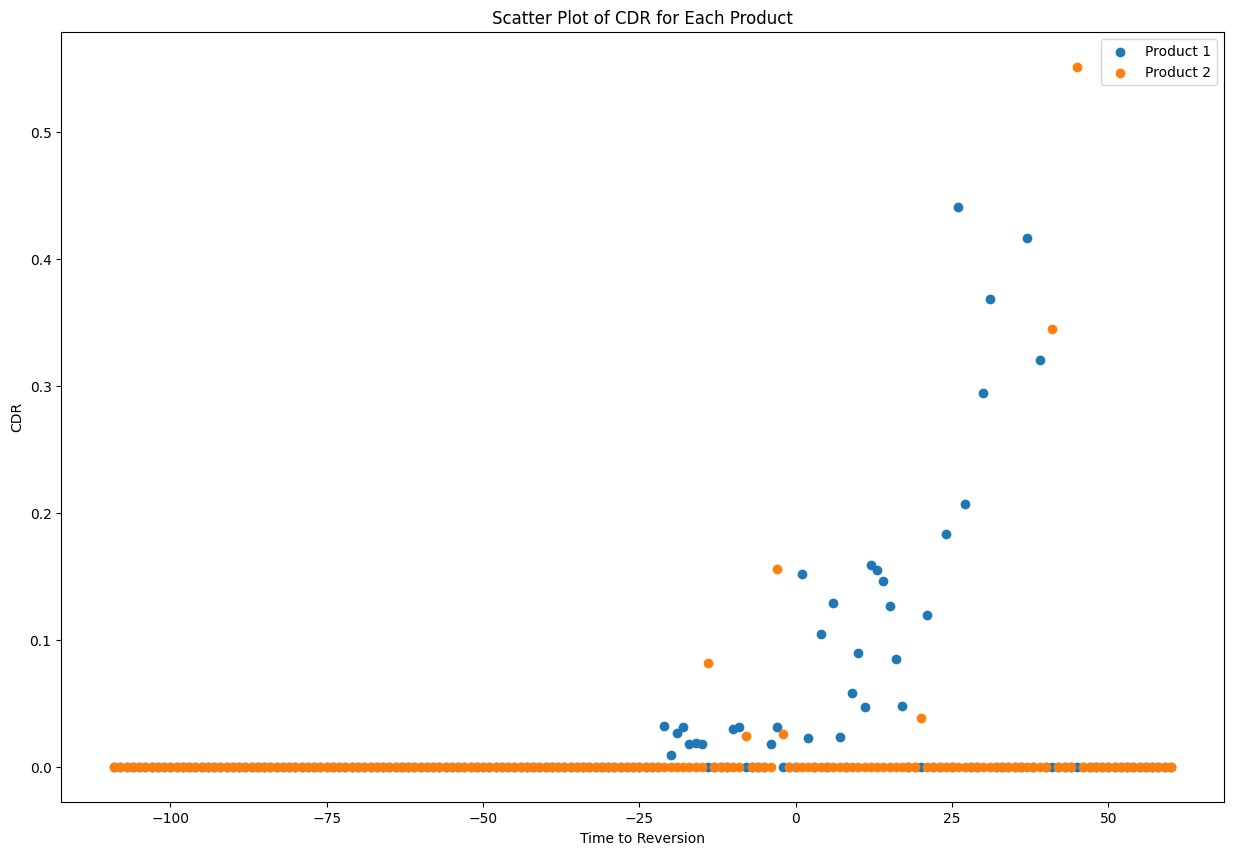

In [6]:
from matplotlib import pyplot as plt
prepayment_rate = portfolio_prepayment_rate(timeseries, ['time_to_reversion', 'product'])
# Get unique products
products = prepayment_rate['product'].unique()

# prepayment_rate = prepayment_rate[prepayment_rate.index >= 0]

# Plot scatter plots for each product
plt.figure(figsize=(15, 10))
for product in products:
    product_data = prepayment_rate[prepayment_rate['product'] == product]
    plt.scatter(product_data.index, product_data['CPR'], label=f'Product {product}')

plt.title('Scatter Plot of CPR for Each Product')
plt.xlabel('Time to Reversion')
plt.ylabel('CPR')
plt.legend()
plt.show()

default_rate = cumulative_default_rate(timeseries, ['time_to_reversion', 'product'])
# default_rate = default_rate[default_rate.index >= 0]

# Plot scatter plots for each product
plt.figure(figsize=(15, 10))
for product in products:
    product_data = default_rate[default_rate['product'] == product]
    plt.scatter(product_data.index, product_data['CDR'], label=f'Product {product}')

plt.title('Scatter Plot of CDR for Each Product')
plt.xlabel('Time to Reversion')
plt.ylabel('CDR')
plt.legend()
plt.show()


## Question 7

### **Objective**
**Question 7**: Using your function, construct Recovery Curves split by year of default ("Default Vintage")

### **Steps**

1. **Using Existing Functionality**: Update the function pameters.
2. **Plotting the results**

In [7]:
from matplotlib import pyplot as plt
recovery_rate = cumulative_recovery_rate(timeseries, ['months_since_default', 'year_of_default'])
# Get unique products
years = recovery_rate['year_of_default'].unique()
# Filtering out years of non-defaulted mortgages
recovery_rate = recovery_rate[recovery_rate.index >= 0]
years = years[years>0]

# Plot scatter plots for each product
plt.figure(figsize=(15, 10))
for year in years:
    product_data = recovery_rate[recovery_rate['year_of_default'] == year]
    plt.plot(product_data.index, product_data['Recovery'], label=f'Year {year}')

plt.title('Default Vintage')
plt.xlabel('Months Since Default')
plt.ylabel('Recovery rate')
plt.legend()
plt.show()

## Question 8

### **Objective**
**Question 8**: Decompose your Recovery Curve in Q7 into two stage calibration: (1) Probability of Recovery by Time Since Default and (2) Recovery as a % of EAD

### **Function: `create_probability_of_default`**

#### **Purpose**
Calculates the probability of recovery for groups of loans.

#### **Steps**
1. **Initialize Variables**: 
    - `results` to store the results.
    - `recoveries` to count the total recoveries.
    - `total_defaults` to count the total defaults.
2. **Group Data**: The dataframe is grouped by the specified indices (default is `['months_since_default', 'year_of_default']`).
3. **Iterate Through Groups**:
    - Skip groups where the first index (`months_since_default`) is less than 0.
    - Sum the recoveries and defaults for the group.
    - Calculate the probability of recovery.
    - Store the result in a dictionary.
4. **Create DataFrame**: Convert the results list into a pandas DataFrame and set the index.
5. **Sort DataFrame**: Sort the DataFrame by the specified group indices.
6. **Return**: Return the resulting DataFrame.

### **Function: `create_recovery_rate_from_rec_over_ead`**

#### **Purpose**
Calculates the recovery rate from post-default recoveries over exposure at default (EAD) for groups of loans.

#### **Steps**
1. **Calculate Post-Default Recovery**: Invoke the `post_default_recovery_by_month` function to calculate post-default recoveries.
2. **Initialize Variables**:
    - `results` to store the results.
    - `recoveries` as a zero array for each loan ID.
    - `total_defaults` to count the total defaults.
3. **Group Data**: The dataframe is grouped by the specified indices (default is `['months_since_default', 'year_of_default']`).
4. **Iterate Through Groups**:
    - Skip groups where the first index (`months_since_default`) is less than 0.
    - Update recoveries for each loan ID in the group.
    - Sum the exposure at default (EAD) for the group.
    - Calculate the recovery rate from recoveries over EAD.
    - Store the result in a dictionary.
5. **Create DataFrame**: Convert the results list into a pandas DataFrame and set the index.
6. **Sort DataFrame**: Sort the DataFrame by the specified group indices.
7. **Return**: Return the resulting DataFrame.

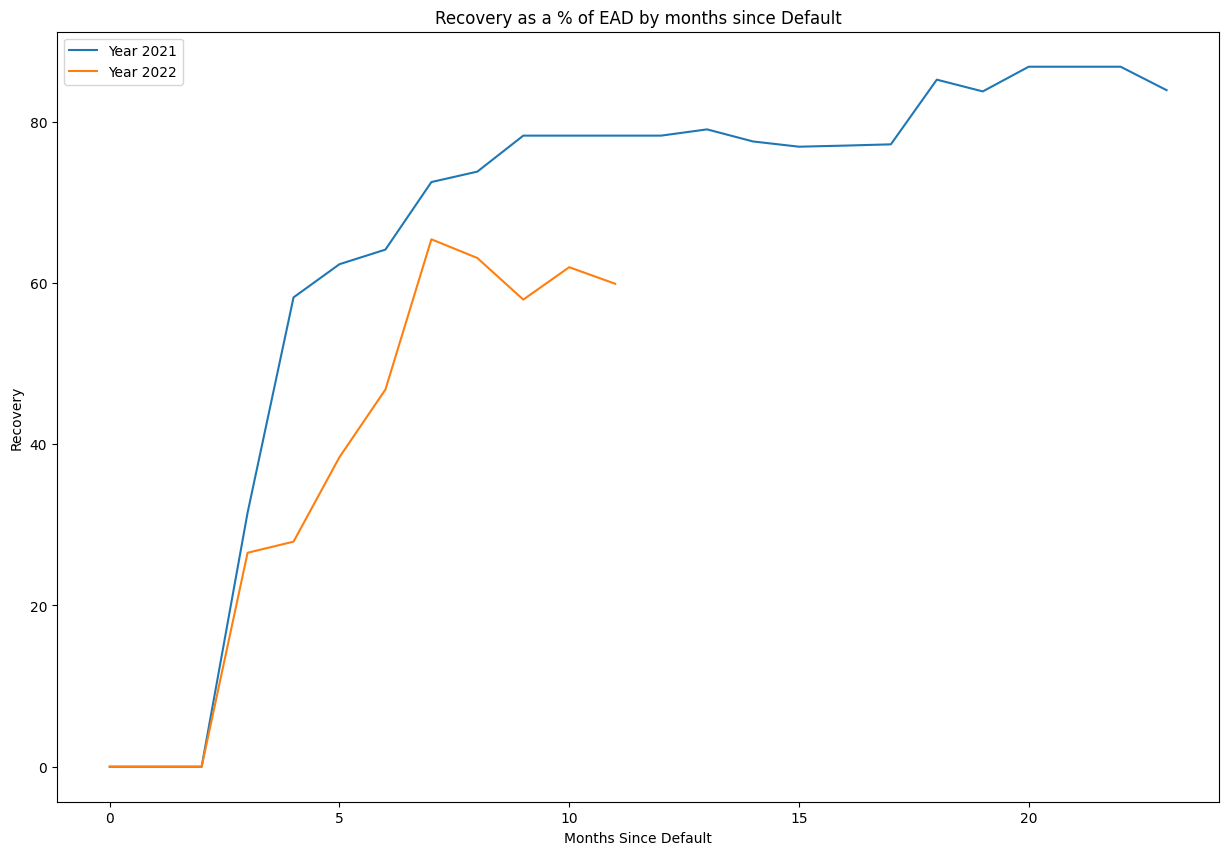

In [8]:
from timeseries_formater.metric_functions import create_probability_of_default
probability_of_recovery = create_probability_of_default(timeseries, ['months_since_default', 'year_of_default'])
years = probability_of_recovery['year_of_default'].unique()

years = years[years>0]

plt.figure(figsize=(15, 10))
for year in years:
    product_data = probability_of_recovery[probability_of_recovery['year_of_default'] == year]
    plt.plot(product_data.index, product_data['Probability_of_recovery'], label=f'Year {year}')

plt.title('Probability of recovery by months since Default')
plt.xlabel('Months Since Default')
plt.ylabel('Probability')
plt.legend()
plt.show()

from timeseries_formater.metric_functions import create_recovery_rate_from_rec_over_ead
recovery_rec_over_ead = create_recovery_rate_from_rec_over_ead(timeseries, ['months_since_default', 'year_of_default'])
years = recovery_rec_over_ead['year_of_default'].unique()

years = years[years>0]

plt.figure(figsize=(15, 10))
for year in years:
    product_data = recovery_rec_over_ead[recovery_rec_over_ead['year_of_default'] == year]
    plt.plot(product_data.index, product_data['recovery_rate_from_rec_over_ead'], label=f'Year {year}')

plt.title('Recovery as a % of EAD by months since Default')
plt.xlabel('Months Since Default')
plt.ylabel('Recovery')
plt.legend()
plt.show()

## Question 9 + 10a

### **Objective**
**Question 9**: Build a Python Cashflow Model that allows the user to forecasts expected cashflows on a loan-by-loan basis using input CPR / CDR and Recovery Curves.

Use your model to run the following scenarios:

1. Base-case: Using the CPR/CDR/Recovery vectors sized in Q3-Q5.

### **Steps**

1. **Import Required Libraries and Functions**:

2. **Calculate Curves**:
    - Calculate the prepayment (`cpr_curve`), default (`cdr_curve`), and recovery (`recovery_curve`) rates using the respective functions.
    - Clip the curves and convert them to numpy arrays for further processing.

3. **Prepare Loan Parameters**:
    - Group the timeseries data by `loan_id`.
    - For each loan, extract relevant parameters and append them to the `loan_params` list.

4. **Run Mortgage Model**:
    - The `run_mortgage_model` function simulates the mortgage data based on the prepared loan parameters.

5. **Calculate Monthly Rates**:
    - Calculate monthly prepayment, default, and recovery rates based on the simulated portfolio-level data.

6. **Print Differences**:
    - Print the differences between the average monthly rates and the actual curves to assess the accuracy of the simulation.

7. **Visualize Results**:
    - Create scatter plots to compare the simulated monthly rates with the actual curves.
    
### **Additional Functions**

- **`process_loan`**: Processes each loan individually to simulate various loan metrics.
- **`parallel_process_loans`**: Processes multiple loans in parallel to improve performance.
- **`get_monthly_results`**: Aggregates the results of the loan simulations to get total monthly metrics.
- **`run_mortgage_model`**: Main function to run the mortgage model, process loans in parallel, and aggregate the results.


Function 'parallel_process_loans' executed in: 1.059098 seconds
Difference between Monthly Prepayment Rate average vs Realised Prepayment Rate average = -0.00028988636668855533
Difference between Monthly Default Rate average vs Realised Default Rate average = -1.0449157878825003e-17
Difference between Monthly Recovery Rate average vs Realised Recovery Rate average = -26.015090142235707


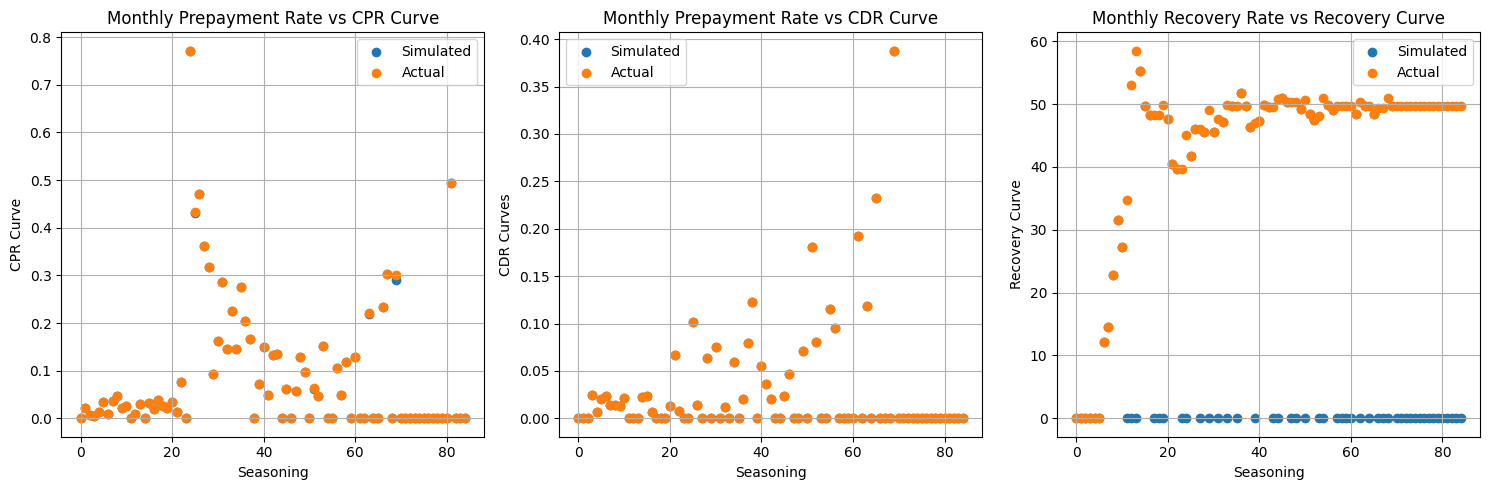

In [9]:
import numpy as np
from utilities.df_utilities import clip_df_at_given_index_and_convert_to_numpy_array
from timeseries_formater.constants import SMALL_FLOAT
from mortgage_model_fast import run_mortgage_model

cpr_curve = portfolio_prepayment_rate(timeseries, ['seasoning'])
cdr_curve = cumulative_default_rate(timeseries, ['seasoning'])
recovery_curve = cumulative_recovery_rate(timeseries, ['seasoning'])

cpr_curve = clip_df_at_given_index_and_convert_to_numpy_array(cpr_curve, 0)
cdr_curve = clip_df_at_given_index_and_convert_to_numpy_array(cdr_curve, 0)
recovery_curve = clip_df_at_given_index_and_convert_to_numpy_array(recovery_curve, 0)

assert cpr_curve.shape == cdr_curve.shape == recovery_curve.shape, 'Curve Shapes are not Consistent, please check'

grouped = timeseries.groupby('loan_id')

loan_params = []

boe_base_rate = 0.0525

for name, group in grouped:
    index_where_seasoning_is_0 = np.where(group['seasoning'] == 0)[0][0]
    row_where_index_seasoning_is_0 = group.loc[group.index[index_where_seasoning_is_0]]
    assert row_where_index_seasoning_is_0['MonthEndBalances'] != 0, 'Loan Month End balance at seasoning is 0'
    loan_params.append(
        {
            'loan_id': row_where_index_seasoning_is_0['loan_id'],
            'current_balance': row_where_index_seasoning_is_0['MonthEndBalances'],
            'fixed_pre_reversion_rate': row_where_index_seasoning_is_0['pre_reversion_fixed_rate'],
            'post_reversion_margin': row_where_index_seasoning_is_0['post_reversion_boe_margin'],
            'months_to_maturity': len(cpr_curve),
            'repayment_method': 'Interest Only',
            'boe_curve': np.zeros_like(cpr_curve) * boe_base_rate,
            'scenario': ['base'],
            'cpr_curve': cpr_curve,
            'cdr_curve': cdr_curve,
            'recovery_curve': recovery_curve,
            'time_to_reversion': -row_where_index_seasoning_is_0['time_to_reversion'],
            'product': row_where_index_seasoning_is_0['product']
        }
    )



# todo Runtime is about 1 second for N = 1,630 which is not great. I can fix this if I get time but I did not want to
#  sacrifice debugging interpretability (df output is easier to read by a human, especially if not in production);
#  To improve speed I would use multidimensional np arrays for storage and then split them in chunks for dask to
#  parse more efficiently.

mortgage_level_data, portfolio_level_data = run_mortgage_model(loan_params)

monthly_prepayment_rate = 1 - np.power(1 - portfolio_level_data['monthly_prepayments'] / portfolio_level_data['monthly_opening_balance'], 12)
monthly_default_rate = 1 - np.power(1 - portfolio_level_data['monthly_defaults'] / portfolio_level_data['monthly_opening_balance'], 12)
monthly_recovery_rate = 100 * portfolio_level_data['monthly_recoveries'] / (portfolio_level_data['monthly_defaults'] + SMALL_FLOAT)

print(f'Difference between Monthly Prepayment Rate average vs Realised Prepayment Rate average = {np.average(monthly_prepayment_rate - cpr_curve)}')
print(f'Difference between Monthly Default Rate average vs Realised Default Rate average = {np.average(monthly_default_rate - cdr_curve)}')
print(f'Difference between Monthly Recovery Rate average vs Realised Recovery Rate average = {np.average(monthly_recovery_rate - recovery_curve)}')


# Plotting scatter plots
plt.figure(figsize=(15, 5))

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 1)
plt.scatter(np.arange(len(cpr_curve)), monthly_prepayment_rate, label='Simulated')
plt.scatter(np.arange(len(cpr_curve)), cpr_curve, label='Actual')
plt.xlabel('Seasoning')
plt.ylabel('CPR Curve')
plt.legend()
plt.title('Monthly Prepayment Rate vs CPR Curve')
plt.grid(True)

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 2)
plt.scatter(np.arange(len(cdr_curve)), monthly_default_rate, label='Simulated')
plt.scatter(np.arange(len(cdr_curve)), cdr_curve, label='Actual')
plt.xlabel('Seasoning')
plt.ylabel('CDR Curves')
plt.legend()
plt.title('Monthly Prepayment Rate vs CDR Curve')
plt.grid(True)

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 3)
plt.scatter(np.arange(len(recovery_curve)), monthly_recovery_rate, label='Simulated')
plt.scatter(np.arange(len(recovery_curve)), recovery_curve, label='Actual')
plt.xlabel('Seasoning')
plt.ylabel('Recovery Curve')
plt.title('Monthly Recovery Rate vs Recovery Curve')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


## Question 10

### **Objective**
Use your model to run the following scenarios:

2. Base-case but CPR is 2x Post-Reversion.
3. Base-case but CPR is 2x Post-Reversion on Product 2 Borrowers.
4. Base-case but 100% CPR on Product 1 Borrowers at the month of reversion (i.e., no increased interest payments are made).
5. Base-case but Recoveries occur linearly over 24 months post-default.

In [10]:
### Scenario 2

loan_params = []
grouped = timeseries.groupby('loan_id')
for name, group in grouped:
    index_where_seasoning_is_0 = np.where(group['seasoning'] == 0)[0][0]
    row_where_index_seasoning_is_0 = group.loc[group.index[index_where_seasoning_is_0]]
    assert row_where_index_seasoning_is_0['MonthEndBalances'] != 0, 'Loan Month End balance at seasoning is 0'
    loan_params.append(
        {
            'loan_id': row_where_index_seasoning_is_0['loan_id'],
            'current_balance': row_where_index_seasoning_is_0['MonthEndBalances'],
            'fixed_pre_reversion_rate': row_where_index_seasoning_is_0['pre_reversion_fixed_rate'],
            'post_reversion_margin': row_where_index_seasoning_is_0['post_reversion_boe_margin'],
            'months_to_maturity': len(cpr_curve),
            'repayment_method': 'Interest Only',
            'boe_curve': np.zeros_like(cpr_curve) * boe_base_rate,
            'scenario': [{'metric': 'CPR', 'factor': 2, 'filter': {'PostReversion': True}}],
            'cpr_curve': cpr_curve,
            'cdr_curve': cdr_curve,
            'recovery_curve': recovery_curve,
            'time_to_reversion': -row_where_index_seasoning_is_0['time_to_reversion'],
            'product': row_where_index_seasoning_is_0['product']
        }
    )

mortgage_level_data, portfolio_level_data = run_mortgage_model(loan_params)

monthly_prepayment_rate = 1 - np.power(1 - portfolio_level_data['monthly_prepayments'] / portfolio_level_data['monthly_opening_balance'], 12)
monthly_default_rate = 1 - np.power(1 - portfolio_level_data['monthly_defaults'] / portfolio_level_data['monthly_opening_balance'], 12)
monthly_recovery_rate = 100 * portfolio_level_data['monthly_recoveries'] / (portfolio_level_data['monthly_defaults'] + SMALL_FLOAT)

# Plotting scatter plots
plt.figure(figsize=(15, 5))

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 1)
plt.plot(np.arange(len(cpr_curve)), monthly_prepayment_rate, label='Scenario')
plt.plot(np.arange(len(cpr_curve)), cpr_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('CPR Curve')
plt.legend()
plt.title('Monthly Prepayment Rate vs CPR Curve')
plt.grid(True)

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 2)
plt.plot(np.arange(len(cdr_curve)), monthly_default_rate, label='Scenario')
plt.plot(np.arange(len(cdr_curve)), cdr_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('CDR Curves')
plt.legend()
plt.title('Monthly Prepayment Rate vs CDR Curve')
plt.grid(True)

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 3)
plt.plot(np.arange(len(recovery_curve)), monthly_recovery_rate, label='Scenario')
plt.plot(np.arange(len(recovery_curve)), recovery_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('Recovery Curve')
plt.title('Monthly Recovery Rate vs Recovery Curve')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


Function 'parallel_process_loans' executed in: 1.107975 seconds


Function 'parallel_process_loans' executed in: 1.127570 seconds


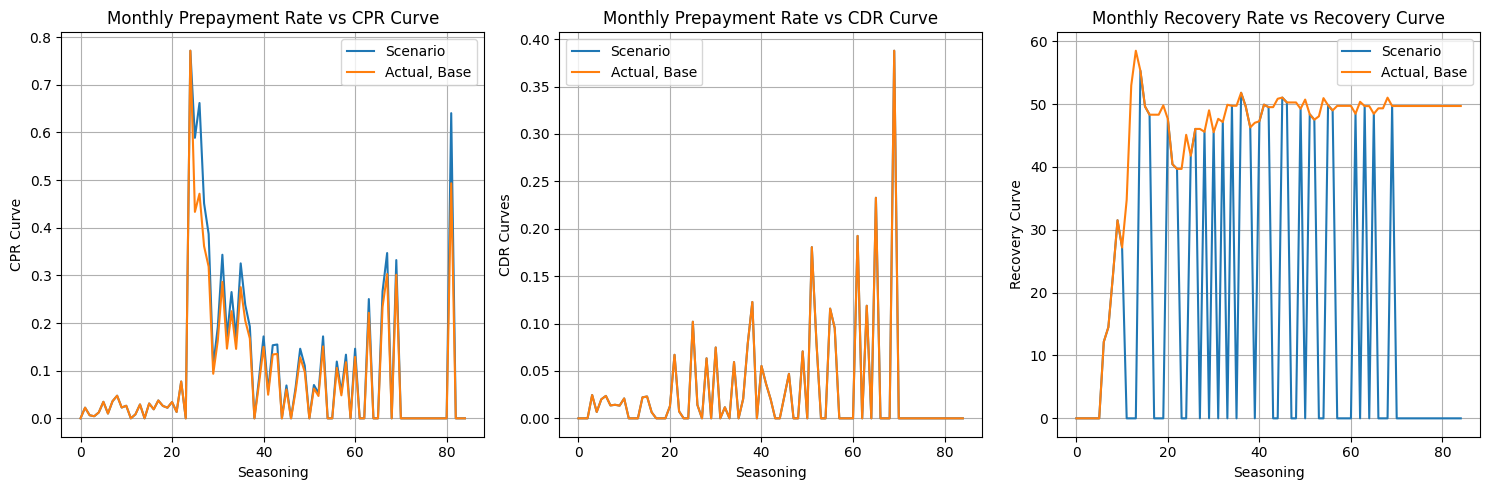

In [11]:
### Scenario 3

loan_params = []
grouped = timeseries.groupby('loan_id')
for name, group in grouped:
    index_where_seasoning_is_0 = np.where(group['seasoning'] == 0)[0][0]
    row_where_index_seasoning_is_0 = group.loc[group.index[index_where_seasoning_is_0]]
    assert row_where_index_seasoning_is_0['MonthEndBalances'] != 0, 'Loan Month End balance at seasoning is 0'
    loan_params.append(
        {
            'loan_id': row_where_index_seasoning_is_0['loan_id'],
            'current_balance': row_where_index_seasoning_is_0['MonthEndBalances'],
            'fixed_pre_reversion_rate': row_where_index_seasoning_is_0['pre_reversion_fixed_rate'],
            'post_reversion_margin': row_where_index_seasoning_is_0['post_reversion_boe_margin'],
            'months_to_maturity': len(cpr_curve),
            'repayment_method': 'Interest Only',
            'boe_curve': np.zeros_like(cpr_curve) * boe_base_rate,
            'scenario': [{'metric': 'CPR', 'factor': 2, 'filter': {'Product': 2, 'PostReversion': True}}],
            'cpr_curve': cpr_curve,
            'cdr_curve': cdr_curve,
            'recovery_curve': recovery_curve,
            'time_to_reversion': -row_where_index_seasoning_is_0['time_to_reversion'],
            'product': row_where_index_seasoning_is_0['product']
        }
    )

mortgage_level_data, portfolio_level_data = run_mortgage_model(loan_params)

monthly_prepayment_rate = 1 - np.power(1 - portfolio_level_data['monthly_prepayments'] / portfolio_level_data['monthly_opening_balance'], 12)
monthly_default_rate = 1 - np.power(1 - portfolio_level_data['monthly_defaults'] / portfolio_level_data['monthly_opening_balance'], 12)
monthly_recovery_rate = 100 * portfolio_level_data['monthly_recoveries'] / (portfolio_level_data['monthly_defaults'] + SMALL_FLOAT)

# Plotting scatter plots
plt.figure(figsize=(15, 5))

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 1)
plt.plot(np.arange(len(cpr_curve)), monthly_prepayment_rate, label='Scenario')
plt.plot(np.arange(len(cpr_curve)), cpr_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('CPR Curve')
plt.legend()
plt.title('Monthly Prepayment Rate vs CPR Curve')
plt.grid(True)

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 2)
plt.plot(np.arange(len(cdr_curve)), monthly_default_rate, label='Scenario')
plt.plot(np.arange(len(cdr_curve)), cdr_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('CDR Curves')
plt.legend()
plt.title('Monthly Prepayment Rate vs CDR Curve')
plt.grid(True)

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 3)
plt.plot(np.arange(len(recovery_curve)), monthly_recovery_rate, label='Scenario')
plt.plot(np.arange(len(recovery_curve)), recovery_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('Recovery Curve')
plt.title('Monthly Recovery Rate vs Recovery Curve')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


Function 'parallel_process_loans' executed in: 1.138309 seconds


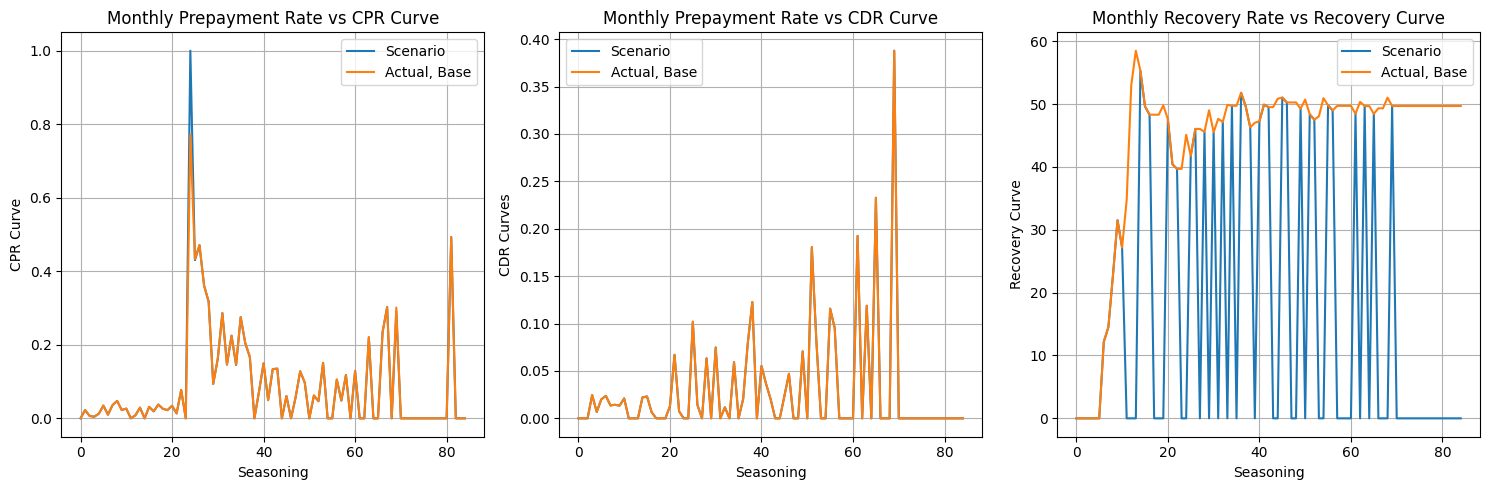

In [12]:
### Scenario 4 factor is 80% at reversion date so multiplying by 10 will be rounded to 100%

loan_params = []
grouped = timeseries.groupby('loan_id')
for name, group in grouped:
    index_where_seasoning_is_0 = np.where(group['seasoning'] == 0)[0][0]
    row_where_index_seasoning_is_0 = group.loc[group.index[index_where_seasoning_is_0]]
    assert row_where_index_seasoning_is_0['MonthEndBalances'] != 0, 'Loan Month End balance at seasoning is 0'
    loan_params.append(
        {
            'loan_id': row_where_index_seasoning_is_0['loan_id'],
            'current_balance': row_where_index_seasoning_is_0['MonthEndBalances'],
            'fixed_pre_reversion_rate': row_where_index_seasoning_is_0['pre_reversion_fixed_rate'],
            'post_reversion_margin': row_where_index_seasoning_is_0['post_reversion_boe_margin'],
            'months_to_maturity': len(cpr_curve),
            'repayment_method': 'Interest Only',
            'boe_curve': np.zeros_like(cpr_curve) * boe_base_rate,
            'scenario': [{'metric': 'CPR', 'factor': 10, 'filter': {'Product': 1, 'AtReversion': True}}],
            'cpr_curve': cpr_curve,
            'cdr_curve': cdr_curve,
            'recovery_curve': recovery_curve,
            'time_to_reversion': -row_where_index_seasoning_is_0['time_to_reversion'],
            'product': row_where_index_seasoning_is_0['product']
        }
    )

mortgage_level_data, portfolio_level_data = run_mortgage_model(loan_params)

monthly_prepayment_rate = 1 - np.power(1 - portfolio_level_data['monthly_prepayments'] / portfolio_level_data['monthly_opening_balance'], 12)
monthly_default_rate = 1 - np.power(1 - portfolio_level_data['monthly_defaults'] / portfolio_level_data['monthly_opening_balance'], 12)
monthly_recovery_rate = 100 * portfolio_level_data['monthly_recoveries'] / (portfolio_level_data['monthly_defaults'] + SMALL_FLOAT)

# Plotting scatter plots
plt.figure(figsize=(15, 5))

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 1)
plt.plot(np.arange(len(cpr_curve)), monthly_prepayment_rate, label='Scenario')
plt.plot(np.arange(len(cpr_curve)), cpr_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('CPR Curve')
plt.legend()
plt.title('Monthly Prepayment Rate vs CPR Curve')
plt.grid(True)

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 2)
plt.plot(np.arange(len(cdr_curve)), monthly_default_rate, label='Scenario')
plt.plot(np.arange(len(cdr_curve)), cdr_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('CDR Curves')
plt.legend()
plt.title('Monthly Prepayment Rate vs CDR Curve')
plt.grid(True)

# Scatter plot for monthly_prepayment_rate vs cpr_curve
plt.subplot(1, 3, 3)
plt.plot(np.arange(len(recovery_curve)), monthly_recovery_rate, label='Scenario')
plt.plot(np.arange(len(recovery_curve)), recovery_curve, label='Actual, Base')
plt.xlabel('Seasoning')
plt.ylabel('Recovery Curve')
plt.title('Monthly Recovery Rate vs Recovery Curve')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


## Question 11

### **Objective**
Include a section on Sanity Checks / Error catching in your model. This is important and should give you confidence in the numbers output by your model.

### Sanity Checks Implemented in the Model

1. **Minimum Value Checks for Default and Prepayment Rates**:
    - In the `process_loan` function, default and prepayment rates are constrained using the `min` function to ensure they do not exceed 1.
    ```python
    defaults[i] = (1 - np.power(1 - min(cdr[i], 1), 1/12)) * expected_opening_performing_balance[i]
    ...
    expected_prepayments[i] = (1 - np.power(1 - min(cpr[i], 1), 1/12)) * expected_balance_pre_period_prepays[i]
    ```

2. **Balance Check at Seasoning Zero**:
    - The loan's month-end balance is checked to ensure it is not zero at the seasoning point.
    ```python
    assert row_where_index_seasoning_is_0['MonthEndBalances'] != 0, 'Loan Month End balance at seasoning is 0'
    ```

3. **Scenario Parser Sanity Check**:
    - The `scenario_parser` function applies sanity checks to ensure the factors and metrics are correctly parsed and applied.
    ```python
    if '-' in modifier:
        factor, metric = modifier.split('-')
        factor = float(factor[:-1])
        return factor, metric.upper()
    else:
        raise ValueError(f"Invalid format: {modifier}")
    ```

4. **Consistency Check of Curves**:
    - The shapes of the `cpr_curve`, `cdr_curve`, and `recovery_curve` are checked to ensure they are consistent before proceeding.
    ```python
    assert cpr_curve.shape == cdr_curve.shape == recovery_curve.shape, 'Curve Shapes are not Consistent, please check'
    ```

5. **Handling Negative and Zero Values**:
    - The `process_loan` function includes checks to handle and adjust for negative and zero values, ensuring that calculations remain valid.

6. **Survival Percentage Calculation**:
    - A sanity check ensures that the survival percentage post-default is calculated correctly to avoid division by zero.
    ```python
    survival_pct_post_default[i] = expected_balance_period_post_defaults[i] / opening_balance[i]
    ```

7. **Expected Loss Calculation**:
    - The expected loss is calculated to ensure it does not result in negative values.
    ```python
    expected_loss[i] = (1 - recovery_by_month[i] / 100) * expected_new_defaults[i]
    ```

8. **Closing Default Balance Rounding**:
    - The closing default balance is rounded to avoid floating-point precision issues.
    ```python
    expected_closing_default_balance[i] = round(expected_opening_default_balance[i] + expected_new_defaults[i] - expected_recoveries[i] - expected_loss[i])
    ```

9. **Parallel Processing Sanity Check**:
    - The `parallel_process_loans` function includes checks to ensure delayed computations are correctly initiated and results are computed accurately.
    ```python
    delayed_results = [delayed(process_loan)(row) for row in loan_params_list]
    ...
    results = compute(delayed_results)
    ```

10. **Loan Parameters Consistency**:
    - Consistency checks for loan parameters to ensure they are correctly initialized and passed to the `process_loan` function.
    ```python
    'loan_id': row_where_index_seasoning_is_0['loan_id'],
    'current_balance': row_where_index_seasoning_is_0['MonthEndBalances'],
    ```

### Comments 

Important sanity checks include feedback to the user of the code when incorrect input is provided and checking metrics during loan processing. I have also provided human readable outputs (at the cost of computational time) in many steps so that the use can debug the output. 
